In [1]:
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm import tqdm
from stable_baselines3 import A2C, DQN
from stable_baselines3.common.evaluation import evaluate_policy

from crl.utils.graphing import despine
from discretise import build_grid_tiling

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
discount = 0.99
dqn_args = {
    # "n_timesteps": 50_000,
    "policy": "MlpPolicy",
    "learning_rate": 2.3e-3,
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_starts": 1000,
    "gamma": discount,
    "target_update_interval": 10,
    "train_freq": 256,
    "gradient_steps": 128,
    "exploration_fraction": 0.16,
    "exploration_final_eps": 0.04,
    "policy_kwargs": dict(net_arch=[256, 256]),
}

model = DQN(env=env, seed=5, **dqn_args)

model.learn(total_timesteps=50_000, progress_bar=True)
vec_env = model.get_env()

Output()

In [3]:
eval_env = gym.make('CartPole-v1')
# eval_env.unwrapped.length = 3
# eval_env.unwrapped.masscart = 10

eval_vec_env = DQN('MlpPolicy', env=eval_env).get_env()

In [4]:
# from rliable import library as rly
# from rliable import metrics, get_interval_estimates

# ep_rewards, ep_lengths = evaluate_policy(model, eval_vec_env, n_eval_episodes=10, return_episode_rewards=True)
# ep_rewards = np.array(ep_rewards)
# ep_rewards = ep_rewards.reshape(-1, 1)
# aggregate_func = lambda x: np.array([metrics.aggregate_iqm(x)])

# vals = {'DQN': ep_rewards}

# aggregate_scores, aggregate_score_cis = get_interval_estimates(vals, aggregate_func, reps=50_000)
# aggregate_scores, aggregate_score_cis

## Conformal stuff

The plan - I want to be able to S-A condition conformal predictors on the Q function - and then pessimistically extract results from it. Some thoughts:

1. Conformal prediction is usually symmetric. That means that if a particular action is better than expected, it will expand the prediction set and cause problems: this paper might have some stuff on asymmetric adjustments in response to bias: https://openreview.net/pdf?id=v8RDgaEtE2
2. To do SA conditioning, the first simple thing I'm going to do is chop up the state space into a grid. Another, maybe superior option would be to introduce tile coding (see [PyFixedReps](https://github.com/andnp/PyFixedReps)) - but would need to come up with a system to combine multiple prediction sets (presumably just take the largest)
3. So here's the strategy:
    1. Q network predicts Q values
    2. SA-grid conformal predictor records the predicted Q value, and the SARSA value - the conformal score is the mod distance to the SARSA value
    3. outputs a prediction interval
    4. Argmax is taken over the minima of the prediction intervals -> action

What do I think will happen. In Cartpole, sometimes at a certain angle/velocity the agent needs to push left to maintain the rod's position. As the pole gets longer and this becomes wrong, the SA-conditioned interval will grow - reducing the agent's estimate of the Q value of that decision. The other decision, going right, may lead to a still-vertical pole, which makes the option higher value than estimated -> note this is why we need to only account for NEGATIVE mod distance in the conformal prediction score. Actually let's quickly read the asymmetric adjustment paper to get a better sense.

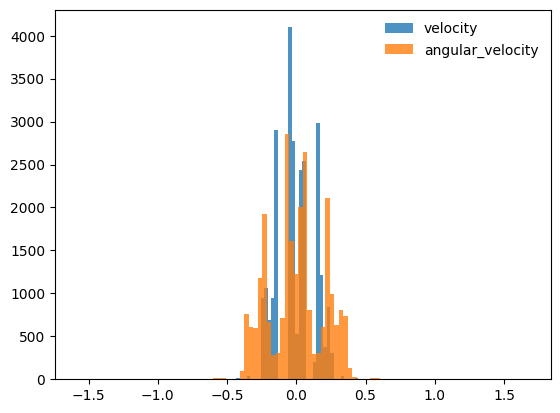

In [5]:
velocities, angular_velocities, positions, angles = [], [], [], []
stats = [
    {"label": "position", "vals": []},
    {"label": "velocity", "vals": []},
    {"label": "angle", "vals": []},
    {"label": "angular_velocity", "vals": []},
]
for episode in range(50):
    obs = vec_env.reset()
    for _id in range(4):
        stats[_id]['vals'].append(obs[0, _id])
    for step in range(500):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        for _id in range(4):
            stats[_id]['vals'].append(obs[0, _id])
        if done:
            continue

for _id in [1, 3]:
    plt.hist(stats[_id]['vals'], bins=100, label=stats[_id]['label'], alpha=0.8)
plt.legend(frameon=False);

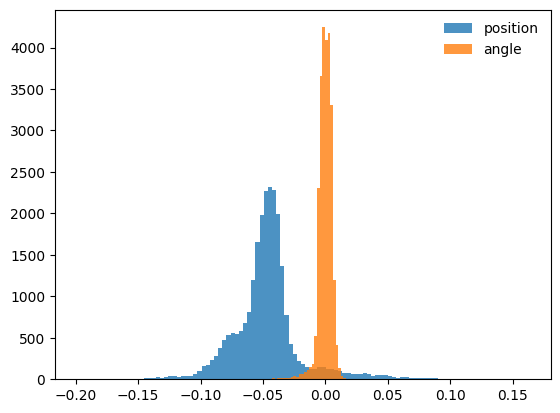

In [6]:
for _id in [0, 2]:
    plt.hist(stats[_id]['vals'], bins=100, label=stats[_id]['label'], alpha=0.8)
plt.legend(frameon=False);

In [7]:

# compute mins and maxes of the tiling according to the quantiles of the distribution
obs_quantile = 0.1 # 95% coverage
maxs = np.zeros(4)
mins = np.zeros(4)
for dim in range(4):
    vals = stats[dim]['vals']
    mins[dim], maxs[dim] = np.quantile(vals, obs_quantile), np.quantile(vals, 1 - obs_quantile)

num_bins = np.array([6, 6, 6, 6])  # Different bin count per dimension
discretise, n_discrete_states = build_grid_tiling(mins, maxs, num_bins)

Grid tiling: 2,592 states (1296 states x 2 actions)


In [8]:
from buffer import ReplayBuffer
from collections import deque

def collect_transitions(env: gym.Env, n_transitions: int = 100_000):
    # TODO: this could stop recording transitions more intelligently if it just updated regressors as it went.
    'run episodes and record SARSA transitions to a replay buffer'
    buffer = ReplayBuffer(capacity=n_transitions)
    obs = env.reset()
    for _ in range(n_transitions):
        action, _ = model.predict(obs, deterministic=True)
        next_obs, reward, done, info = env.step(action)

    # Next action required for SARSA
        next_action, _ = model.predict(next_obs, deterministic=True)

    # Store transition (s, a, r, s', a', done)
        buffer.push(obs, action, reward, next_obs, next_action, done)

        obs = next_obs
        if done:
            obs = env.reset()               # start new episode

    return buffer

buffer = collect_transitions(vec_env, n_transitions=100_000)

In [ ]:
# from discretise import build_kdtree_tiling
# disc_ids, discretise, n_discrete_states = build_kdtree_tiling(buffer=buffer, min_leaf=1024, include_actions=True)

Built tree with 128 nodes


In [27]:

# 1. build up a conformal set and conformalise regressors for each state-action pair (essentially measuring Bellman errors)
def score(y_pred, y_true):
    return y_pred - y_true

maxlen = 500
def fill_regressors(model, buffer, n_discrete_states: int, maxlen: int=500):
    regressors = {}
    for (sa,) in np.ndindex((n_discrete_states)):
        regressors[sa] = dict(
        y_preds=deque(maxlen=maxlen),
        y_trues=deque(maxlen=maxlen),
        scores=deque(maxlen=maxlen),
    )

# now construct the datasets
    for transition in buffer[:-1]:
    # extract a transition - add it to the calibration set
        with torch.no_grad():
            q_pred = model.q_net(model.policy.obs_to_tensor(transition.state)[0]) 
            y_pred = q_pred[0, transition.action]
            if transition.done:
                y_true = transition.reward
            else:
                q_true = model.q_net(model.policy.obs_to_tensor(transition.next_state)[0])
                y_true = transition.reward[0] + discount * q_true[0, transition.next_action]

            obs_disc = discretise(transition.state, transition.action)[0]

            regressors[obs_disc]["y_preds"].append(y_pred)
            regressors[obs_disc]["y_trues"].append(y_true)
            regressors[obs_disc]["scores"].append(score(y_pred, y_true))
    
    return regressors

# fill_regressors(score, maxlen)
regressors = fill_regressors(model, buffer, n_discrete_states)

/var/folders/m0/pnzx_cys7lg5w_yvwhqtc7dm0000gn/T/ipykernel_40168/2488857146.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return y_pred - y_true


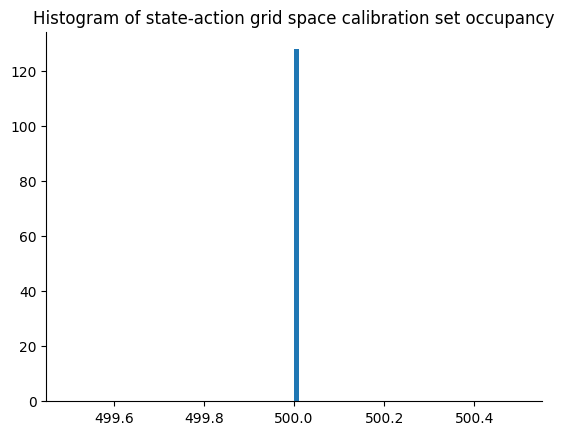

In [ ]:
# most of these sets are empty - could use much tighter bounds
alpha = 0.1
min_calib = 50
def compute_lower_bounds(alpha, min_calib, regressors):
    n_calibs = []
    qhat_global = 0

    for sa, reg in regressors.items():
        n_calib = len(reg['y_preds'])
        n_calibs.append(n_calib)
        if n_calib < min_calib:
            continue
    
    # conformalise
        q_level = min(1.0, np.ceil((n_calib + 1) * (1 - alpha)) / n_calib)
        qhat = np.quantile(reg['scores'], q_level, method="higher")

        reg['qhat'] = qhat
        # Set a global, pessimistic correction for un-visited state action pairs.
        if qhat > qhat_global:
            qhat_global = qhat
            
    return regressors, n_calibs, qhat_global

regressors, n_calibs, qhat_global = compute_lower_bounds(alpha, min_calib, regressors)

plt.hist(n_calibs, bins=100)
plt.title('Histogram of state-action grid space calibration set occupancy')
despine(plt.gca())

In [29]:
from typing import Any


def run_eval(
    num_eps: int, conformalise: bool, ep_env: gym.Env, regressors: dict[dict[str, Any]]
) -> list[float]:
    obs = ep_env.reset()
    episodic_returns = []

    for ep in range(num_eps):
        for t in range(500):
            q_vals = model.q_net(model.policy.obs_to_tensor(obs)[0]).flatten()
            # adjust the action using the conformal prediction lower bound
            obs_disc_0 = discretise(obs, np.array([0]))[0]  # [0]
            obs_disc_1 = discretise(obs, np.array([1]))[0]  # [0]
            if conformalise:
                q_vals[0] = q_vals[0] - regressors[obs_disc_0].get("qhat", qhat_global)
                q_vals[1] = q_vals[1] - regressors[obs_disc_1].get("qhat", qhat_global)

            action = q_vals.argmax().numpy().reshape(1)

            obs, reward, done, info = ep_env.step(action)

            if done:
                ep_return = info[0]["episode"]["r"]
                episodic_returns.append(ep_return)
                break
    return episodic_returns


def instantiate_eval_env(length, masscart):
    # attrs = ['gravity', 'force_mag', 'masscart', 'masspole', 'length', 'polemass_length']
    eval_env = gym.make("CartPole-v1")
    eval_vec_env = DQN("MlpPolicy", env=eval_env).get_env()
    eval_env.unwrapped.masscart = masscart  # default 1.0
    eval_env.unwrapped.length = length  # default 0.5
    return eval_vec_env


def run_shift_experiment(
    length: float = 0.5, masscart: float = 1.0, num_eps: int = 250
):
    # instantiate the shifted env
    eval_vec_env = instantiate_eval_env(length, masscart)

    # run an experiment with and without the CP lower-bound correction
    num_eps = 250
    returns_conf = run_eval(num_eps=num_eps, conformalise=True, ep_env=eval_vec_env, regressors=regressors)
    returns_noconf = run_eval(num_eps=num_eps, conformalise=False, ep_env=eval_vec_env, regressors=regressors)

    exp_result = {
        "length": length,
        "masscart": masscart,
        "returns_conf": returns_conf,
        "returns_noconf": returns_noconf,
        "num_episodes": num_eps,
    }
    return exp_result

In [30]:
# # # alternative - nominal calibration vs test calibration
# num_eps = 250
# length = 0.5
# masscart = 1.0
# def run_test_calibration_experiment(length=0.5, masscart=1.0,num_eps=250):
#     ep_env = instantiate_eval_env(length, masscart)

#     # first build the regressors dict - this is a best case scenario to start since we're not doing it online.
#     ep_buffer = collect_transitions(ep_env, n_transitions=500_000)
#     ep_regressors = fill_regressors(model, ep_buffer, n_discrete_states)
#     ep_regressors, _, _ = compute_lower_bounds(alpha=0.1, min_calib=50, regressors=ep_regressors)

#     episode_returns = run_eval(num_eps=num_eps, conformalise=True, ep_env=ep_env, regressors=ep_regressors)
#     return episode_returns

# results = []
# for length in (pbar := tqdm(np.linspace(0.1, 2.0, 20))):
#     pbar.set_description(f'l={length:.1f}')
#     results.append(run_test_calibration_experiment(length=length))

# test_calibration_returns = np.array(results)

In [31]:
# results
# test_calibration_returns.shape
# plt.plot(test_calibration_returns, marker='o')

In [32]:
results = []
for length in (pbar := tqdm(np.linspace(0.1, 2.0, 20))):
    pbar.set_description(f'l={length:.1f}')
    results.append(run_shift_experiment(length=length))

conf_returns = np.array([res['returns_conf'] for res in results])
noconf_returns = np.array([res['returns_noconf'] for res in results])
lengths = np.array([res['length'] for res in results])

l=2.0: 100%|██████████| 20/20 [02:01<00:00,  6.06s/it]


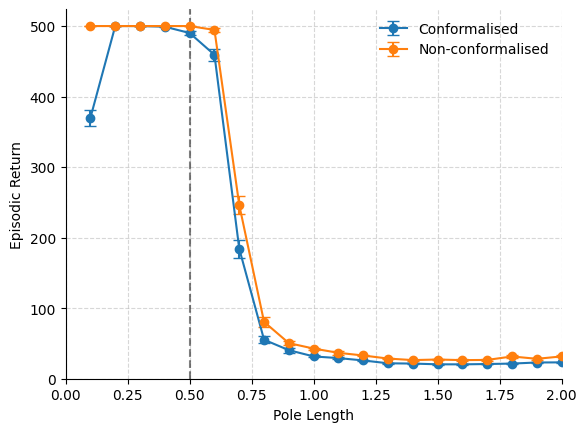

On average, CP is 0.82x better


In [33]:

# Conformalised returns
mean_conf = conf_returns.mean(axis=1)
se_conf   = conf_returns.std(axis=1) / np.sqrt(250)
plt.errorbar(
    lengths,
    mean_conf,
    yerr=se_conf,
    marker='o',
    linestyle='-',
    capsize=4,
    label='Conformalised'
)

# Non-conformalised returns
mean_no   = noconf_returns.mean(axis=1)
se_no     = noconf_returns.std(axis=1) / np.sqrt(250)
plt.errorbar(
    lengths,
    mean_no,
    yerr=se_no,
    marker='o',
    linestyle='-',
    capsize=4,
    label='Non-conformalised'
)

# # test-time conformalisation returns
# mean_test = test_calibration_returns.mean(axis=1)
# se_test = test_calibration_returns.mean(axis=1) / np.sqrt(250)
# plt.errorbar(
#     lengths,
#     mean_test,
#     yerr=se_test,
#     marker='o',
#     linestyle='-',
#     capsize=4,
#     label='Test-time Calibration'
# )

plt.ylabel('Episodic Return')
plt.xlabel('Pole Length')
plt.axvline(0.5, linestyle='--', c='k', alpha=0.5)
plt.xlim(0, 2.0)
plt.ylim(0, None)
despine(plt.gca())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=False)
plt.show()

print(f'On average, CP is {np.mean(mean_conf / mean_no):.2f}x better')

In [57]:
# (conf_returns.mean(axis=1)/ noconf_returns.mean(axis=1))

In [58]:
# print(f'{n_discrete_states:,} total grid states, ')
# print(f'Non-conformalised: {np.mean(episodic_returns_noconf):.2f} ± {np.std(episodic_returns_noconf)/np.sqrt(num_eps+1):.2f}')
# print(f'    Conformalised: {np.mean(episodic_returns_conf):.2f} ± {np.std(episodic_returns_conf)/np.sqrt(num_eps+1):.2f}')

In [59]:
# 256 states
# Non-conformalised: 56.04 ± 1.99
#     Conformalised: 69.93 ± 1.66
# different policy - hence, the drop
# 1,296 total grid states
# Non-conformalised: 22.21 ± 0.11
#     Conformalised: 22.15 ± 0.11

In [60]:
# alpha=0.1
# n_calib = 100
# q_level = min(1.0, np.ceil((n_calib + 1) * (1 - alpha)) / n_calib)

# y_true = np.random.randn(n_calib)
# y_pred_over = np.random.randn(n_calib) + 0.5 # overestimation - risky
# y_pred_under = np.random.randn(n_calib) - 0.5 # underestimation - less immediately risky

# scores_over = score(y_pred_over, y_true)
# scores_under = score(y_pred_under, y_true)
# qhat_over = np.quantile(scores_over, q_level, method="higher")
# qhat_under = np.quantile(scores_under, q_level, method="higher")
# qhat_over.round(2), qhat_under.round(2) # smaller adjustment for the underestimation case